In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

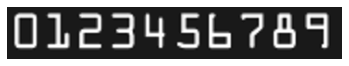

In [11]:
# load the reference OCR-A image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
# and invert it, such that the digits appear as *white* on a *black*
ref = cv2.imread("creditcard_digits2.jpg" , 0 )
plt.figure()
plt.axis("off")
plt.imshow(ref , cmap = 'gray')

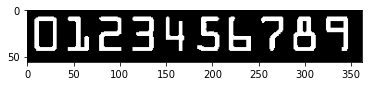

In [12]:
_, ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(ref , cmap = 'gray')

In [13]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
# sort them from left to right, and initialize a dictionary to map
# digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[1] if imutils.is_cv3() else refCnts[0]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [14]:
digits = {}


In [15]:
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:(y + h), x:(x + w)]
    roi2 = cv2.resize(roi, (57, 88))
 
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

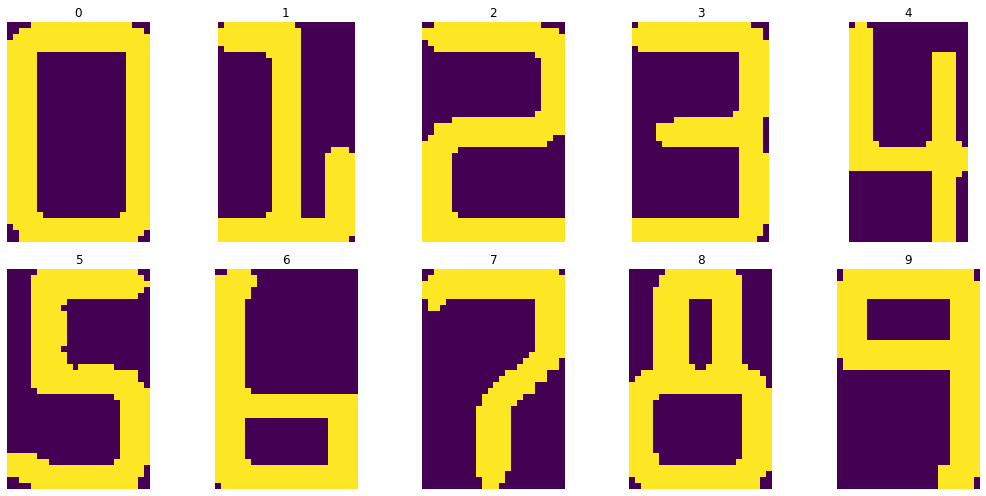

In [18]:
plt.figure( figsize = (15 , 7 ) )

for i in range( 0 , 10 ):
    plt.subplot(2 , 5 , i+1 )
    plt.title( i )
    plt.axis("off")
    plt.imshow(digits[i])
    
plt.tight_layout()
plt.show()

In [19]:
# initialize a rectangular (wider than it is tall) and square
# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

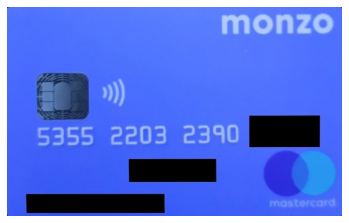

In [20]:
image = cv2.imread('credit_card_color.jpg')
plt.figure()
plt.axis("off")
plt.imshow(image)

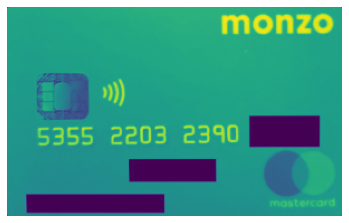

In [21]:
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray)

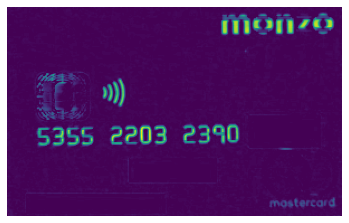

In [22]:
# apply a tophat (whitehat) morphological operator to find light
# regions against a dark background (i.e., the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.figure()
plt.axis("off")
plt.imshow(tophat)

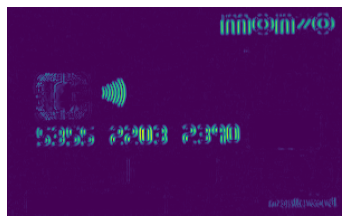

In [23]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

plt.figure()
plt.axis("off")
plt.imshow(gradX)

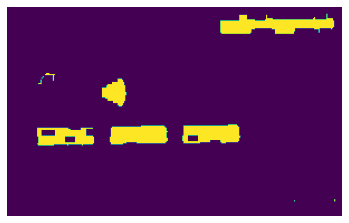

In [24]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [25]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv3() else cnts[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [26]:
locs = []

In [27]:
# loop over the contours
for (i, c) in enumerate(cnts):
    # compute the bounding box of the contour, then use the
    # bounding box coordinates to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
 
    # since credit cards used a fixed size fonts with 4 groups
    # of 4 digits, we can prune potential contours based on the
    # aspect ratio
    if ar > 2.5 and ar < 4.5:
        # contours can further be pruned on minimum/maximum width
        # and height
        if (w > 40 and w < 70) and (h > 10 and h < 20):
            # append the bounding box region of the digits group
            # to our locations list
            locs.append((x, y, w, h))

In [28]:
# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])

In [29]:
locs

[(27, 108, 51, 16), (92, 106, 52, 17), (157, 105, 52, 17)]

In [30]:
output = []

In [31]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []
 
    # extract the group ROI of 4 digits from the grayscale image,
    # then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    # detect the contours of each individual digit in the group,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    
    digitCnts = digitCnts[1] if imutils.is_cv3() else digitCnts[0]
    # digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    digitCnts = contours.sort_contours(digitCnts,
    method="left-to-right")[0]

    # loop over the digit contours
    for c in digitCnts:
        # compute the bounding box of the individual digit, extract
        # the digit, and resize it to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
 
        # initialize a list of template matching scores	
        scores = []
 
        # loop over the reference digit name and digit ROI
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI,
                                       cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
 
        # the classification for the digit ROI will be the reference
        # digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
        # draw the digit classifications around the group
        cv2.rectangle(image, (gX - 5, gY - 5),
                      (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
 
    # update the output digits list
    output.extend(groupOutput)

In [32]:
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 096996990999


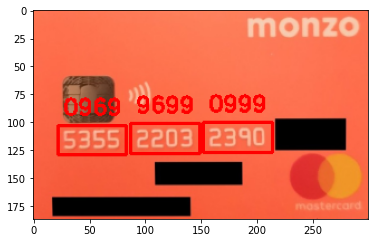

In [33]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))